In [57]:
import os
import boto3
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras import callbacks

from tensorflow.keras.applications.vgg19 import (VGG19, preprocess_input, decode_predictions)
from tensorflow.keras.applications import MobileNet
from config import aws_access_key_id, aws_secret_access_key

In [2]:
# Set your AWS credentials and region
aws_access_key_id = aws_access_key_id
aws_secret_access_key = aws_secret_access_key 
region_name = "us-east-2"
bucket_name = "capstone-pill-images"
# train_prefix = "dataset/train/"
# validation_prefix = "dataset/valid/"
data_prefix = "data/data"


# Create an S3 client
s3 = boto3.client(
    's3',
     aws_access_key_id=aws_access_key_id,
     aws_secret_access_key=aws_secret_access_key,
     region_name=region_name
    )

In [3]:

# Function to download images from S3 bucket to a local directory with subdirectories
def download_images_from_s3(bucket_name, prefix, local_directory):
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
    for obj in response.get('Contents', []):
        key = obj['Key']

        # Extract the drug name from the key
        # Split the key at the second "/" to get the correct drug name

    for obj in response.get('Contents', []):
        key = obj['Key']
        local_path = os.path.join(local_directory, os.path.relpath(key, prefix))  # Use os.path.relpath to get the relative path
        os.makedirs(os.path.dirname(local_path), exist_ok=True)  # Create intermediate directories if they don't exist
        s3.download_file(bucket_name, key, local_path)





In [4]:
# Download training images
local_drug_directory = "local_drug_directory"
download_images_from_s3(bucket_name, data_prefix, local_drug_directory)


In [5]:
# define loading parameters
img_height = 224
img_width = 224
batch_size = 1

In [6]:
import splitfolders
splitfolders.ratio('local_drug_directory', output="output", seed=1337, ratio=(.8, 0.1,0.1)) 

Copying files: 552 files [00:01, 520.69 files/s] 


In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_dir = "output/train/"
valid_dir = "output/val/"

In [9]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_width,img_height),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode="categorical"
                                                   )

Found 437 images belonging to 23 classes.


In [10]:
validation_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size=(img_width,img_height),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode="categorical"
                                                   )

Found 46 images belonging to 23 classes.


In [1]:
class_names = train_generator.class_indices.keys()
class_names

NameError: name 'train_generator' is not defined

In [ ]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D

In [63]:
base_model = MobileNet(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

 )                                                               
                                                                 
 conv_dw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_dw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D  (None, 14, 14, 512)       4608      
 )        

In [64]:
model = Sequential()

model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(23, activation="softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 23)                23575     
                                                                 
Total params: 3252439 (12.41 MB)
Trainable params: 23575 (92.09 KB)
Non-trainable params: 3228864 (12.32 MB)
_________________________________________________________________


In [65]:
checkpoint = callbacks.ModelCheckpoint(
    filepath='pill.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode = 'max')

In [66]:
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [67]:
model_fitted = model.fit(train_generator, epochs=2, validation_data = validation_generator)


Epoch 1/2
437/437 [==============================] - 9s 19ms/step - loss: 0.9806 - accuracy: 0.7941 - val_loss: 0.0724 - val_accuracy: 1.0000
Epoch 2/2
437/437 [==============================] - 8s 19ms/step - loss: 0.0444 - accuracy: 1.0000 - val_loss: 0.0253 - val_accuracy: 1.0000


In [68]:
model_loss, model_accuracy = model.evaluate(validation_generator, verbose=2)
print(f" loss : {round(model_loss)*100}%, accurcay : {round(model_accuracy,2)*100}%")

46/46 - 1s - loss: 0.0253 - accuracy: 1.0000 - 776ms/epoch - 17ms/step
 loss : 0%, accurcay : 100.0%


In [23]:
# model_df = pd.DataFrame(model_fitted.history)

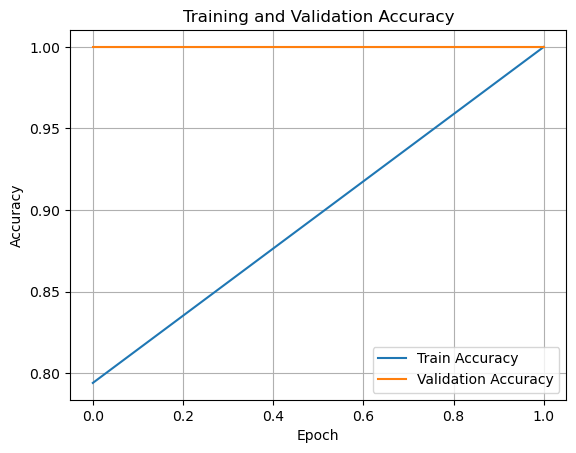

In [74]:
# Visualize the training history w.r.t to 
plt.plot(model_fitted.history['accuracy'], label='Train Accuracy')
plt.plot(model_fitted.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Accuracy')

plt.show()

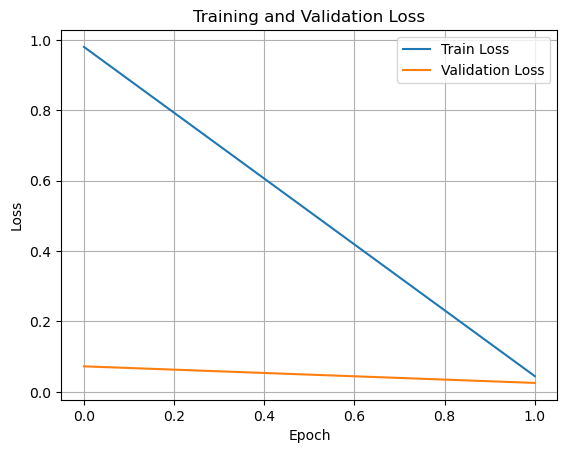

In [72]:
plt.plot(model_fitted.history['loss'], label='Train Loss')
plt.plot(model_fitted.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()

In [18]:
# model.save('MobileNet_02.keras')

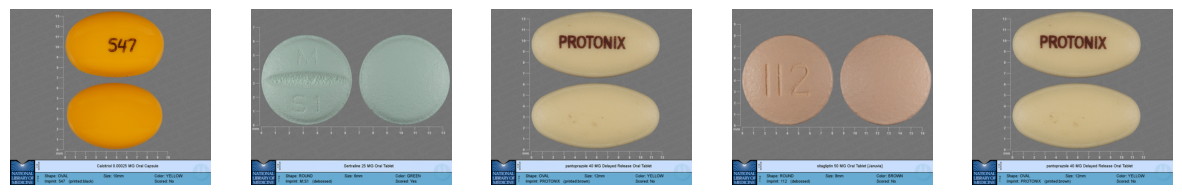

In [19]:

def show_sample_images(local_directory):
    # Go into the local directory and put all subdirectories in a List
    subdirectories = [d for d in os.listdir(local_directory) if os.path.isdir(os.path.join(local_directory, d))]

    # Check if there are any subdirectories
    if not subdirectories:
        print("No subdirectories found in the directory.")
        return

    # Collect all image files from all subdirectories
    all_image_files = []
    for subdirectory in subdirectories:
        subdirectory_path = os.path.join(local_directory, subdirectory)

        # List all image files in the subdirectory
        image_files = [f for f in os.listdir(subdirectory_path) if f.lower().endswith(('.jpg', '.jpeg'))]

        # Add the image files to the combined list
        all_image_files.extend(os.path.join(subdirectory_path, f) for f in image_files)

    # Shuffle the combined list of image files
    random.shuffle(all_image_files)

    # Set the number of random images to display
    num_images_to_display = 5

    # Create subplots to display images side by side
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))  # Adjust figsize as needed

    # Loop to select and display 5 random images
    for i in range(num_images_to_display):
        # Check if there are still image files available
        if not all_image_files:
            break

        # Pop a random image from the combined list
        random_image_file = all_image_files.pop()

        # Load and display the randomly selected image
        img = mpimg.imread(random_image_file)

        # Display the image in the subplot
        axes[i].imshow(img)
        axes[i].axis('off')  # Turn off axis labels

    # Show the subplots
    plt.show()

# Example usage
show_sample_images(local_drug_directory)